### Building the SVM
Here we will aim to represent the conversations using Bag-Of-Words (BOW) with a TF-IDF weighing scheme and then build our SVM Suspicious Conversations Identifier (SCI).

First we read in the training data and labels.

In [1]:
import xml.etree.ElementTree as ET
import csv


def get_labels_dict(data_path):
    labels_dict = {}
    with open(data_path + 'sci_labels.csv', 'r') as f:
        file = csv.reader(f)
        for row in file:
            labels_dict[row[0]] = row[1]
    return labels_dict


def get_features_labels(root, labels_dict):
    corpus = [] # each row is a string formed from all messages in a conversations
    labels = [] # each row is 0 or 1, corresponds to label for same row in corpus

    for conversation in root:
        string = " "
        for message in conversation:
            text = message.find('text').text
            if text is not None:
                string = string + "\r\n" + text 
        corpus.append(string)
        labels.append(int(labels_dict[conversation.get('id')]))
    return corpus, labels

In [2]:
train_data_path = '../../data/svm_training_data/'
training_xml = ET.parse(train_data_path + 'training_data.xml')
train_root = training_xml.getroot()

test_data_path = '../../data/svm_test_data/'
test_data_src = '../../data/pan12-sexual-predator-identification-test-corpus-2012-05-21/'
test_xml = ET.parse(test_data_src + 'pan12-sexual-predator-identification-test-corpus-2012-05-17.xml')
test_root = test_xml.getroot()

train_corpus, train_labels = get_features_labels(train_root, get_labels_dict(train_data_path))
test_corpus, test_labels = get_features_labels(test_root, get_labels_dict(test_data_path))

We will now represent all conversations using BOW with TF-IDF weighing scheme.
- [] Customize Vectorizer Parameters like normailize
- [] Use hashing vectorization to save space and see if performance affected (https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/)


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
# from sklearn.model_selection import train_test_split
import numpy as np

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_corpus)
X_test = vectorizer.transform(test_corpus)

X_train = scipy.sparse.csr_matrix(X_train)
y_train = np.array(train_labels)
X_test = scipy.sparse.csr_matrix(X_test)
y_test = np.array(test_labels)

# X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=87)
# print("Train data shape:{}\r\nTest data shape:{}".format(X_train.shape, X_test.shape))

We can now build the SVM and do cross validation to explore the accuracy of each kernel and hyperparameter.

linear, c=0.1, Accuracy: 0.9914983559705324
linear, c=0.2, Accuracy: 0.9941509547394756
linear, c=0.30000000000000004, Accuracy: 0.9946950336898865
linear, c=0.4, Accuracy: 0.9950350310076445
linear, c=0.5, Accuracy: 0.9953070936056273
linear, c=0.6, Accuracy: 0.9954431017818413
linear, c=0.7000000000000001, Accuracy: 0.9955111289927256
linear, c=0.8, Accuracy: 0.9955111289927256
linear, c=0.9, Accuracy: 0.99557915620361
linear, c=1.0, Accuracy: 0.9955792024491646
linear, c=1.1, Accuracy: 0.99557915620361
linear, c=1.2000000000000002, Accuracy: 0.9955111289927256
linear, c=1.3000000000000003, Accuracy: 0.9955791099580553
linear, c=1.4000000000000001, Accuracy: 0.9955791099580553
linear, c=1.5000000000000002, Accuracy: 0.9955791099580553
linear, c=1.6, Accuracy: 0.9955791099580553
linear, c=1.7000000000000002, Accuracy: 0.9955791099580553
linear, c=1.8000000000000003, Accuracy: 0.9955791099580553
linear, c=1.9000000000000001, Accuracy: 0.9955791099580553
linear, c=2.0, Accuracy: 0.99564

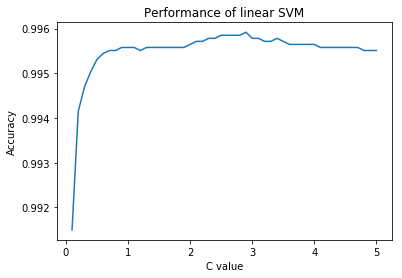

Best performing linear kernel SVM: C=2.9000000000000004, Acc=0.995919246012477


In [8]:
from sklearn import svm
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn import metrics
import heapq
import operator
import numpy as np
from sklearn.svm import LinearSVC

num_fold = 10
k_fold = KFold(num_fold, True, 1)
kernel = 'linear'
acc = []

for coef_c in np.arange(0.1, 5.1, 0.1):
    acc_arr = np.zeros(num_fold)
    ind = 0
    for train_rows, val_rows in k_fold.split(X_train):
#         model = svm.SVC(kernel=kernel, C=coef_c, gamma='auto', random_state=0)
        model = LinearSVC(random_state=0, C=coef_c, loss='squared_hinge', dual=True)
        model.fit(X_train[train_rows], y_train[train_rows])
        pred_y = model.predict(X_train[val_rows])
        acc_arr[ind] = metrics.accuracy_score(y_train[val_rows], pred_y)
        ind += 1
    acc.append([coef_c, np.mean(acc_arr)])
    print("{}, c={}, Accuracy: {}".format(kernel, coef_c, acc[len(acc)-1][1]))
plt.plot([i[0] for i in acc], [i[1] for i in acc])
plt.title("Performance of {} SVM".format(kernel))
plt.xlabel("C value")
plt.ylabel("Accuracy")
# plt.savefig('../output/As1_Qn4.2_' + kernel + '_' + datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.png')
plt.show()
best = heapq.nlargest(1, acc, key=operator.itemgetter(1))[0]
print("Best performing linear kernel SVM: C={}, Acc={}".format(best[0], best[1]))

Now that we have the best linear kernel model, let us test against our test data.

In [10]:
# model = svm.SVC(kernel='linear', C=best[0], gamma='auto', random_state=0)
model = LinearSVC(random_state=0, C=best[0], loss='squared_hinge', dual=True)
model.fit(X_train, y_train)
pred_y = model.predict(X_test)
print(metrics.accuracy_score(y_test, pred_y))

0.9851026249290908


For linear kernel SVM with C coeficient of 1, we are getting an accuracy of 0.98561!

In [6]:
import pickle
import datetime

# save the model to the models folder
filename = '../../models/SCI_SVM_' + "{:.2f}_".format(metrics.accuracy_score(y_test, pred_y)) + datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.sav'
pickle.dump(model, open(filename, 'wb'))